This is the code for creating a Prophet model that predicts occupancy by region.

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


Below are the functions used to prepare the data for the model.  
The csv file contains the following information in each row: the acces point at which it is recorded, the datetime in 15 minute intervals, and the number of connections at this access point.  
-load_data(level, location) takes in level of prediciton (ap, floor, or building), and location of prediction (name of ap, floor number or DBH)   
-add_features(df) adds numerical features such as day of the week, hour, month, and quarter along with binary features such as a binary value for each quarter, weekend, holiday, and active hour (1 if true, 0 if false).  
-create_timeline(df) takes in df and makes sure all possible 15 minute interval is in df and transforms to make sure there are no NA values. Then it subtracts all non-zero count values by when to slightly account for static devices.    


In [60]:
def load_data(level, location):
    """Load CSV and rename columns for Prophet"""
    csv_path = r"2018Q1Q2-15min.csv"
    df = pd.read_csv(csv_path)
    df = df.rename(columns={
        'interval_begin_time': 'ds',
        'count': 'y'
    })
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds').reset_index(drop=True)

    if level == 'ap':
        df = df[df['ap'] == location]
    elif level == 'floor':
        df = df[df['ap'].str.contains('314' + str(location))]
    elif level == 'building':
        df = df[df['ap'].str.split('-').str[0].str[:-1] == location]
    
    df = df.groupby('ds', as_index=False)['y'].sum()
    # df.to_csv('og_df.csv', index=False)
    
    return df

def add_features(df):
    """Add quarter, day, hour, and weekend features"""
    dates = pd.to_datetime(df['ds'])
    months = dates.dt.month
    days = dates.dt.day
    
    # Create month_day for quarter calculation
    month_day = months * 100 + days
    
    # Define quarters
    q1_mask = (month_day >= 924) & (month_day <= 1214)  # Sep 24 - Dec 14
    q2_mask = (month_day >= 102) & (month_day <= 322)   # Jan 2 - Mar 22
    q3_mask = (month_day >= 327) & (month_day <= 614)   # Mar 27 - Jun 14
    q4_mask = (month_day >= 624) & (month_day <= 830)   # Jun 24 - Aug 30
    
    quarter = np.select([q1_mask, q2_mask, q3_mask, q4_mask], [1, 2, 3, 4], default=0)
    
    # all date related features features
    df = df.copy()
    df['quarter'] = quarter
    df['day'] = dates.dt.dayofweek
    df['hour'] = dates.dt.hour
    df['month'] = months

    #binary features
    df['quarter_1'] = (df['quarter'] == 1).astype(int)
    df['quarter_2'] = (df['quarter'] == 2).astype(int) 
    df['quarter_3'] = (df['quarter'] == 3).astype(int)
    df['quarter_4'] = (df['quarter'] == 4).astype(int)
    df['is_weekend'] = (dates.dt.dayofweek >= 5).astype(int)
    df['is_active_hour'] = (df['hour'].between(8, 22)).astype(int)
    return df


def create_timeline(df):
    """Fill missing 15-minute intervals and handle inactive hours"""
    start_date = df['ds'].min().date()
    end_date = df['ds'].max().date()
    
    # Create complete 5-minute timeline
    full_timeline = pd.date_range(
        start=start_date,
        end=end_date + pd.Timedelta(days=1),
        freq='15min'
    )
    
    complete_df = pd.DataFrame({'ds': full_timeline})
    result = complete_df.merge(df[['ds', 'y']], on='ds', how='outer')
    
    # Fill inactive hours (10 PM - 8 AM) with 0
    result['hour'] = result['ds'].dt.hour
    inactive_hours = list(range(22, 24)) + list(range(0, 8))
    inactive_mask = result['hour'].isin(inactive_hours)
    result.loc[inactive_mask & result['y'].isna(), 'y'] = 0
    
    # Forward fill remaining gaps (max 1 hour)
    result['y'] = result['y'].ffill(limit=12)

    #accounts for static devices
    result['y'] = result['y'].apply(lambda x: x - 1 if x > 0 else x)
    
    return result[['ds', 'y']].sort_values('ds').reset_index(drop=True)


Training and Test Split (size of test can be specified but 10 percent of the given data is used as test)

In [61]:
def split_train_test(df, test_size=0.1):
    """Split data into train/test sets"""
    split_idx = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_idx].copy().reset_index(drop=True)
    test_df = df.iloc[split_idx:].copy().reset_index(drop=True)
    
    print(f"Training: {len(train_df)} points | Test: {len(test_df)} points")
    print(f"Train period: {train_df['ds'].min()} to {train_df['ds'].max()}")
    print(f"Test period: {test_df['ds'].min()} to {test_df['ds'].max()}")
    
    return train_df, test_df


Portion of code for creating the model:  
-get_holidays() specifies holiday periods  
-create_and_train_model(config, train_df) takes in a dictionary of hyperparam values, as well as the training data, creates models, scales, trains, and then outputs the model and scaler.  
-test_model(model, test_df, scaler) - fits on test data to test whether model fits properly.

In [62]:
def get_holidays():
    holiday_periods = [
        # Fall 2017
        ("Veterans Day", "2017-11-10", "2017-11-10"),
        ("Thanksgiving", "2017-11-23", "2017-11-24"),
        ("Winter Break", "2017-12-18", "2018-01-02"),
        ("Winter Admin Recess", "2017-12-25", "2018-01-02"),

        # Winter 2018
        ("MLK Day", "2018-01-15", "2018-01-15"),
        ("Presidents Day", "2018-02-19", "2018-02-19"),
        ("Cesar Chavez Day", "2018-03-30", "2018-03-30"),

        # Spring 2018
        ("Memorial Day", "2018-05-28", "2018-05-28"),
        ("Spring Break", "2018-03-26", "2018-03-30"),
    ]

    dfs = []
    for name, start, end in holiday_periods:
        dates = pd.date_range(start=start, end=end, freq="D")
        df = pd.DataFrame({
            "ds": dates,
            "holiday": name
        })
        dfs.append(df)

    holiday_df = pd.concat(dfs, ignore_index=True)
    return holiday_df

def create_and_train_model(config, train_df):
    """Train model with best config and create all visualizations"""
    holidays = get_holidays()
    scaler = MinMaxScaler()

    
    print("Training Prophet model")
    
    #Create model
    model = Prophet(
        holidays=holidays, 
        changepoint_prior_scale=config["changepoint_prior_scale"],
        seasonality_prior_scale=config["seasonality_prior_scale"],
        changepoint_range=config["changepoint_range"],
        daily_seasonality=config["daily_seasonality"],
        weekly_seasonality=config["weekly_seasonality"],
        yearly_seasonality=config["yearly_seasonality"]
    )

    #Quarter 1 seasonality
    model.add_seasonality(
        name='quarterly_pattern1',
        period=config["q1_period"],
        fourier_order=config["q1_fourier_order"],
        prior_scale=config["q1_prior_scale"],
        condition_name='quarter_1'
    )

    #Quarter 2 seasonality
    model.add_seasonality(
        name='quarterly_pattern2',
        period=config["q2_period"],
        fourier_order=config["q2_fourier_order"],
        prior_scale=config["q2_prior_scale"],
        condition_name='quarter_2'
    )

    #Quarter 3 seasonality
    model.add_seasonality(
        name='quarterly_pattern3',
        period=config["q3_period"],
        fourier_order=config["q3_fourier_order"],
        prior_scale=config["q3_prior_scale"],
        condition_name='quarter_3'
    )

    #Quarter 4 seasonality
    model.add_seasonality(
        name='quarterly_pattern4',
        period=config["q4_period"],
        fourier_order=config["q4_fourier_order"],
        prior_scale=config["q4_prior_scale"],
        condition_name='quarter_4'
    )

    #Weekend pattern
    model.add_seasonality(
        name='weekend_pattern',
        period=config["weekend_period"],
        fourier_order=config["weekend_fourier_order"],
        prior_scale=config["weekend_prior_scale"],
        condition_name='is_weekend'
    )

    #active hours pattern
    model.add_seasonality(
        name='active_pattern',
        period=config["active_period"],   
        fourier_order=config["active_fourier_order"],
        prior_scale=config["active_prior_scale"],
        condition_name='is_active_hour'
    )

    #Fit model
    train_df_clean = train_df.dropna(subset=['y'])

    train_df_clean['y'] = scaler.fit_transform(train_df_clean[['y']])
    model.fit(train_df_clean)
    return model, scaler


def test_model(model, test_df, scaler):
    """evaluate model"""
    forecast = model.predict(test_df)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # components = model.plot_components(forecast)
    # components.savefig("components.png")

    forecast['yhat'] = scaler.inverse_transform(forecast[['yhat']])
    forecast['yhat_lower'] = scaler.inverse_transform(forecast[['yhat_lower']])
    forecast['yhat_upper'] = scaler.inverse_transform(forecast[['yhat_upper']])

    return forecast, scaler

transforms our output into binary values, and creates a plot for them  
plot function that graphs the values of out predictions versues the true values  

In [63]:
def make_binary(forecast):
    forecast['ds'] = pd.to_datetime(forecast['ds'])
    for i in range(len(forecast)):
        if forecast.loc[i, 'y'] > 2:
            forecast.loc[i, 'y'] = 1
        else:
            forecast.loc[i, 'y'] = 0
    return forecast

def binary_predictions(forecast, level, location):
    begin = forecast['ds'].min()
    end = forecast['ds'].max()

    df = load_data(level, location)
    for i in range(len(df)):
        if df.loc[i, 'y'] - 2 > 0:
            df.loc[i, 'y'] = 1
        else:
            df.loc[i, 'y'] = 0
    # df = make_binary(df)
    df = df.rename(columns={
        'ds': 'interval_begin_time',
        'y': 'count'
    })
    df['interval_begin_time'] = pd.to_datetime(df['interval_begin_time'])
    df = df[df['interval_begin_time'].between(pd.to_datetime(begin), pd.to_datetime(end))]
    # Ensure datetime for forecast
    forecast['ds'] = pd.to_datetime(forecast['ds'])
    # Only keep valid predictions
    valid_forecast = forecast[~forecast['y'].isna()].copy()
    # Merge forecast with actual counts
    merged = pd.merge(
        valid_forecast,
        df[['interval_begin_time', 'count']],
        left_on='ds',
        right_on='interval_begin_time',
        how='left'
    )
    plot_predictions(merged, level, location, f"{level}{location}-binary_predictions.png")



def plot_predictions(merged, level, id, save_path = None):
    # Fill missing counts with 0
    merged['count'] = merged['count'].fillna(0)

    # Extract aligned series
    actual_dates = merged['ds']
    predictions = merged['y']
    actual_values = merged['count']

    rmse = np.sqrt(mean_squared_error(actual_values, predictions))
    mae = mean_absolute_error(actual_values, predictions)

    # Create the plot
    plt.figure(figsize=(15, 8))
    plt.plot(actual_dates, actual_values, 'g-', linewidth=2, alpha=0.6, label='Actual')
    plt.plot(actual_dates, predictions, 'r-', linewidth=2.5, alpha=1.0, label='Predicted', zorder=10)
    
    # Title, labels, grid
    title = f'{level} {id}\nProphet Model Test Results: Actual vs Predicted\nRMSE: {rmse:.4f}, MAE: {mae:.4f}'
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Number of Connections')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks()
    plt.tight_layout()
    plt.show()
    
    # Save if path provided
    if save_path:
        plt.savefig("all_plots/PROPHET-" + save_path, dpi=300, bbox_inches='tight')
        print(f"Test comparison plot saved to: all_plots/PROPHET-{save_path}")

level can be equal to 'ap', 'floor', 'building'  
location is dependent on level  
'ap':  
"3141-clwa-1100", "3141-clwa-1412", "3141-clwa-1431", "3141-clwa-1433", "3141-clwb-1100", "3141-clwc-1100", "3141-clwd-1100", "3141-clwe-1100", "3142-clwa-2019", "3142-clwa-2039", "3142-clwa-2051", "3142-clwa-2059", "3142-clwa-2065", "3142-clwa-2099", "3142-clwa-2209", "3142-clwa-2219", "3142-clwa-2231", "3143-clwa-3019", "3143-clwa-3039", "3143-clwa-3051", "3143-clwa-3059", "3143-clwa-3065", "3143-clwa-3099", "3143-clwa-3209", "3143-clwa-3219", "3143-clwa-3231", "3144-clwa-4019", "3144-clwa-4039", "3144-clwa-4051", "3144-clwa-4059", "3144-clwa-4065", "3144-clwa-4099", "3144-clwa-4209", "3144-clwa-4219", "3144-clwa-4231", "3145-clwa-5019", "3145-clwa-5039", "3145-clwa-5051", "3145-clwa-5059", "3145-clwa-5065", "3145-clwa-5099", "3145-clwa-5209", "3145-clwa-5219", "3145-clwa-5231", "3146-clwa-6011", "3146-clwa-6029", "3146-clwa-6049", "3146-clwa-6122", "3146-clwa-6131", "3146-clwa-6217", "3146-clwa-6219"  

'floor':  
1, 2, 3, 4, 5, 6  
  
'building':   
'DBH'  

In [66]:
level = 'ap'
location = '3142-clwa-2039'

df = load_data(level, location)
df = create_timeline(df)
df = add_features(df)
train_df, test_df = split_train_test(df)
    
print(f"Final training data: {len(train_df)}")
print(f"Final training data: {len(test_df)}")
    
train_df = train_df.dropna(subset=['y'])
    
print("\nData ready for Prophet!")
print("Train columns:", list(train_df.columns))
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

    # best_config = tune_prophet_model()
best_config = {'changepoint_prior_scale': 0.002,
                'seasonality_prior_scale': 25, 
                'changepoint_range': 0.8528748963397128, 
                'daily_seasonality': True, 
                'weekly_seasonality': True, 'yearly_seasonality': True, 
                'q1_period': 70, 'q1_fourier_order': 30, 'q1_prior_scale': 1, 
                'q2_period': 84, 'q2_fourier_order': 21, 'q2_prior_scale': 320, 
                'q3_period': 90, 'q3_fourier_order': 5, 'q3_prior_scale': 1, 
                'q4_period': 60, 'q4_fourier_order': 15, 'q4_prior_scale': 1, 
                'weekend_period': 7, 'weekend_fourier_order': 30, 'weekend_prior_scale': 50, 
                "active_period": 1, 'active_fourier_order': 22, 'active_prior_scale': 640, 
                'holiday_period': 365, 'holiday_fourier_order': 30, 'holiday_prior_scale': 50}
print(best_config)

model, scaler = create_and_train_model(best_config, train_df)
forecast, scaler = test_model(model, test_df, scaler)



forecasted = forecast[['ds', 'yhat']].reset_index(drop=True)
forecasted = forecasted.rename(columns={'yhat' : 'y'}) 
             
              

Training: 15380 points | Test: 1709 points
Train period: 2017-12-25 00:00:00 to 2018-06-03 04:45:00
Test period: 2018-06-03 05:00:00 to 2018-06-21 00:00:00
Final training data: 15380
Final training data: 1709

Data ready for Prophet!
Train columns: ['ds', 'y', 'quarter', 'day', 'hour', 'month', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'is_weekend', 'is_active_hour']
Train shape: (14809, 12)
Test shape: (1709, 12)
{'changepoint_prior_scale': 0.002, 'seasonality_prior_scale': 25, 'changepoint_range': 0.8528748963397128, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True, 'q1_period': 70, 'q1_fourier_order': 30, 'q1_prior_scale': 1, 'q2_period': 84, 'q2_fourier_order': 21, 'q2_prior_scale': 320, 'q3_period': 90, 'q3_fourier_order': 5, 'q3_prior_scale': 1, 'q4_period': 60, 'q4_fourier_order': 15, 'q4_prior_scale': 1, 'weekend_period': 7, 'weekend_fourier_order': 30, 'weekend_prior_scale': 50, 'active_period': 1, 'active_fourier_order': 22, 'active_

23:33:22 - cmdstanpy - INFO - Chain [1] start processing
23:33:31 - cmdstanpy - INFO - Chain [1] done processing


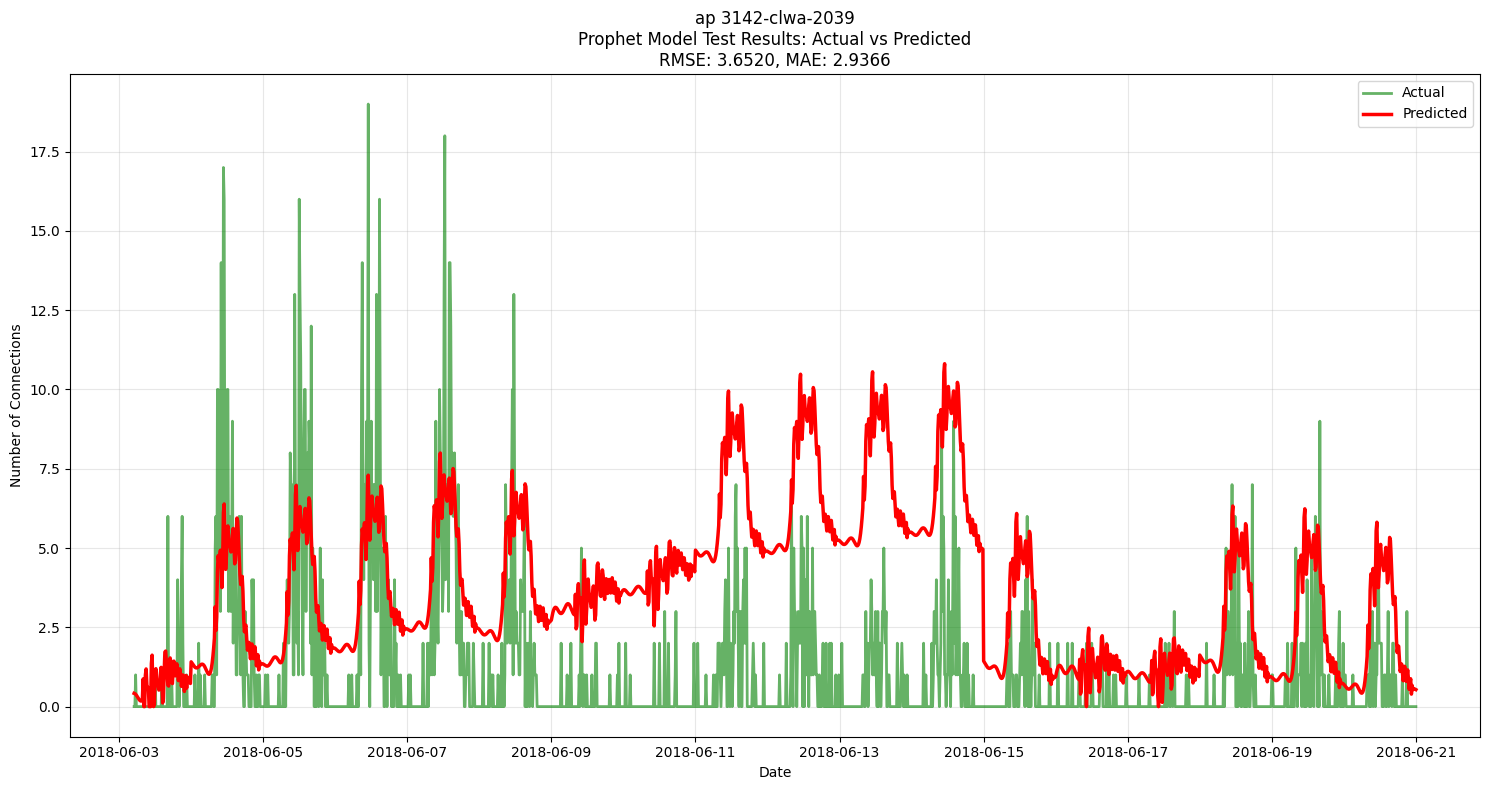

In [67]:
begin = forecasted['ds'].min()
end = forecasted['ds'].max()

# Load and combine data
df = load_data(level, location)
    # df = df[df['ap'] == ap_id]
df = df.rename(columns={
    'ds': 'interval_begin_time',
    'y': 'count'
})
df['interval_begin_time'] = pd.to_datetime(df['interval_begin_time'])
df = df[df['interval_begin_time'].between(pd.to_datetime(begin), pd.to_datetime(end))]

# Ensure datetime for forecast
forecasted['ds'] = pd.to_datetime(forecasted['ds'])
# print(forecasted)
    
# Only keep valid predictions
valid_forecast = forecasted[~forecasted['y'].isna()].copy()

# Merge forecast with actual counts
merged = pd.merge(
    valid_forecast,
    df[['interval_begin_time', 'count']],
    left_on='ds',
    right_on='interval_begin_time',
    how='left'
)

plot_predictions(merged, level, location)#, f'{level}{location}prediction_plot')

In [ ]:
with open(f'occupancy_prophet_models/prophet_{location}{level}.pkl', 'wb') as f:
    pickle.dump(model, f)
with open(f'occupancy_prophet_models/prophet_{location}{level}scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
def predict_future_occupancy(df_features: pd.DataFrame, level: str, location: str, begintime: str, endtime: str):
    """
    """
    start_date = pd.to_datetime(begintime)
    end_date = pd.to_datetime(endtime)
    
    # Create complete 15-minute timeline
    if start_date == end_date:
        full_timeline = pd.date_range(
            start=start_date,
            end=end_date,
            freq='15min'
        )
    else:
        full_timeline = pd.date_range(
            start=start_date,
            end=end_date,
            freq='15min'
        )

    full_timeline = pd.DataFrame({'ds': full_timeline})


    df_features.to_csv("training_tup_fromcsv.csv", index=False)
    
    print("Splitting train/test...")
    train_df = df_features

    test_df = add_features(full_timeline)
    # test_df['y'] = 0
    
    print(f"Final training data: {len(train_df)}")
    print(f"Final training data: {len(test_df)}")
    
    train_df = train_df.dropna(subset=['y'])
    
    print("\nData ready for Prophet!")
    print("Train columns:", list(train_df.columns))
    print("Train shape:", train_df.shape)
    print("Test shape:", test_df.shape)

    # best_config = tune_prophet_model()
    best_config = {'changepoint_prior_scale': 0.002,
                    'seasonality_prior_scale': 25, 
                    'changepoint_range': 0.8528748963397128, 
                    'daily_seasonality': True, 
                    'weekly_seasonality': True, 'yearly_seasonality': True, 
                    'q1_period': 70, 'q1_fourier_order': 30, 'q1_prior_scale': 1, 
                    'q2_period': 84, 'q2_fourier_order': 21, 'q2_prior_scale': 320, 
                    'q3_period': 90, 'q3_fourier_order': 5, 'q3_prior_scale': 1, 
                    'q4_period': 60, 'q4_fourier_order': 15, 'q4_prior_scale': 1, 
                    'weekend_period': 7, 'weekend_fourier_order': 30, 'weekend_prior_scale': 50, 
                    "active_period": 1, 'active_fourier_order': 22, 'active_prior_scale': 640, 
                    'holiday_period': 365, 'holiday_fourier_order': 30, 'holiday_prior_scale': 50}
    print(best_config)
    scaler = MinMaxScaler()

    model, scaler = create_and_train_model(best_config, train_df, scaler)
    forecast, scaler = test_model(model, test_df, scaler)

    print("FINISHED")

    return forecast
    # ray.shutdown()



def occupancy(level: str, location: str, begintime: str, endtime: str):
    csv_path = r"2018Q1Q2-15min.csv"  # UPDATE THIS PATH
    if endtime == None:
        endtime = begintime

    print("Loading data...")
    df = load_data(level, location)

    print("\nCreating complete timeline...")
    df = create_timeline(df)
    df.to_csv('time_line.csv', index=False)
    # train = df.iloc[:-384]
    train = df[df['ds'] < '2018-06-10 00:00:00']
    train.to_csv('training.csv', index=False)
    begin = pd.to_datetime(begintime)
    end = pd.to_datetime(endtime)

    df = load_data(level, location)

    print(begintime)
    print(endtime)


    if train['ds'].min() < begin < train['ds'].max():
            if end <= train['ds'].max():
                print('historical')
                forecasted = df[(df['ds'] >= begin) & (df['ds'] <= end)].reset_index(drop=True)
                forecasted = forecasted[['ds', 'y']]
            else:
                print('half historical half predictive')
                forecasted = df[(df['ds'] >= begin) & (df['ds'] <= train['ds'].max())]
                forecasted = forecasted[['ds', 'y']]
                print(train['ds'].max())
                predictions = predict_future_occupancy(train, level, location, train['ds'].max(), end)
                predictions = predictions[['ds', 'yhat']]
                predictions = predictions.rename(columns={'yhat' : 'y'})
                forecasted = pd.concat([forecasted, predictions], ignore_index=True)
    elif begin >= train['ds'].max(): 
            print('predictive')
            predictions = predict_future_occupancy(train, level, location, begin, end)
            forecasted = predictions[['ds', 'yhat']].reset_index(drop=True)
            forecasted = forecasted.rename(columns={'yhat' : 'y'})
    elif begin < train['ds'].min():
        if end <= train['ds'].min():
            print('predictive')
            predictions = predict_future_occupancy(train, level, location, begin, end)
            forecasted = predictions[['ds', 'yhat']].reset_index(drop=True)
            forecasted = forecasted.rename(columns={'yhat' : 'y'}) 
        else:  
            print('half historical half predictive')
            forecasted = df[(df['ds'] >= train['ds'].min()) & (df['ds'] <= end)]
            forecasted = forecasted[['ds', 'y']]
            print(train['ds'].max())
            predictions = predict_future_occupancy(train, level, location, begin, train['ds'].min())
            predictions = predictions[['ds', 'yhat']]
            predictions = predictions.rename(columns={'yhat' : 'y'})
            forecasted = pd.concat([forecasted, predictions], ignore_index=True)
             
              
    
    return forecasted